In [1]:
import pandas as pd
import rpy2
import readline
import numpy as np
from scipy import stats as scistats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import re

%matplotlib inline

%load_ext rpy2.ipython

In [2]:
def prettify_ax(ax):
    """
    Nifty function we can use to make our axes more pleasant to look at
    """
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    """
    Shortcut to make and 'prettify' a simple figure with 1 axis
    """
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

# Alignment

In [2]:
%%writefile ./build_rat_index.sh
#!/bin/bash

#SBATCH -n 1                            #Number of cores
#SBATCH -N 1                            #Run on 1 node
#SBATCH --mem=16000                      

#SBATCH -t 08:00:00 #Indicate duration using HH:MM:SS
#SBATCH -p general  #Based on your duration

#SBATCH -o ./build_rat_index.out
#SBATCH -e ./build_rat_index.err
#SBATCH --mail-type=ALL
#SBATCH --mail-user=nlarusstone@college.harvard.edu

# --------------
# Fill this part out (and the specific fields above)

subread-buildindex /n/regal/scrb152/Data/Reference/Rattus_norvegicus/Rattus_norvegicus.Rnor_6.0.dna_sm.toplevel.fa -o /n/regal/scrb152/Students/nlarusstone/Rattus_norvegicus.subread_index

Writing ./build_rat_index.sh


In [6]:
%%bash
sbatch ./build_rat_index.sh

Submitted batch job 74908065


Aligning the samples using subjunc

In [79]:
%%bash
tail -n 10 build_rat_index.err

||  [ 70.0% finished ]                                                        ||
||  [ 80.0% finished ]                                                        ||
||  [ 90.0% finished ]                                                        ||
||  [ 100.0% finished ]                                                       ||
||                                                                            ||
||                     Total running time: 39.7 minutes.                      ||
||Index /n/regal/scrb152/Students/nlarusstone/Rattus_norvegicus.subread_ ... ||
||                                                                            ||
\\===================== http://subread.sourceforge.net/ ======================//



In [76]:
%%writefile ./align_rat_spleen_thymus.sh
#!/bin/bash

#SBATCH -n 8                            #The number of cores should match the '--threads' parameter of subjunc
#SBATCH -N 1                            #Run on 1 node
#SBATCH --mem=16000                     

#SBATCH -t 05:00:00 #Indicate duration using HH:MM:SS
#SBATCH -p serial_requeue #Based on your duration               

#SBATCH -o ./rat_alignment_%a.out
#SBATCH -e ./rat_alignment_%a.err
#SBATCH --mail-type=ALL
#SBATCH --mail-user=nlarusstone@college.harvard.edu

# --------------
# Fill this part out (and the specific fields above)
cd /n/scratch
source /n/scrb152/setup.sh

sample_names=(Spl_F_002_1 Spl_F_002_2 Spl_F_002_3 Spl_F_002_4 \
Spl_F_006_1 Spl_F_006_2 Spl_F_006_3 Spl_F_006_4 \
Spl_F_021_1 Spl_F_021_2 Spl_F_021_3 Spl_F_021_4 \
Spl_F_104_1 Spl_F_104_2 Spl_F_104_3 Spl_F_104_4 \
Spl_M_002_1 Spl_M_002_2 Spl_M_002_3 Spl_M_002_4 \
Spl_M_006_1 Spl_M_006_2 Spl_M_006_3 Spl_M_006_4 \
Spl_M_021_1 Spl_M_021_2 Spl_M_021_3 Spl_M_021_4 \
Spl_M_104_1 Spl_M_104_2 Spl_M_104_3 Spl_M_104_4 \
Thy_F_002_1 Thy_F_002_2 Thy_F_002_3 Thy_F_002_4 \
Thy_F_006_1 Thy_F_006_2 Thy_F_006_3 Thy_F_006_4 \
Thy_F_021_1 Thy_F_021_2 Thy_F_021_3 Thy_F_021_4 \
Thy_F_104_1 Thy_F_104_2 Thy_F_104_3 Thy_F_104_4 \
Thy_M_002_1 Thy_M_002_2 Thy_M_002_3 Thy_M_002_4 \
Thy_M_006_1 Thy_M_006_2 Thy_M_006_3 Thy_M_006_4 \
Thy_M_021_1 Thy_M_021_2 Thy_M_021_3 Thy_M_021_4 \
Thy_M_104_1 Thy_M_104_2 Thy_M_104_3 Thy_M_104_4 \
)

chosen_sample_name=${sample_names[${SLURM_ARRAY_TASK_ID}]}
fastq_file=/n/regal/scrb152/Data/Yu_et_al/fastq/"$chosen_sample_name".fastq.gz
bam_file=/n/regal/scrb152/Students/nlarusstone/bam/"$chosen_sample_name".bam

subjunc \
    --index /n/regal/scrb152/Students/nlarusstone/Rattus_norvegicus.subread_index \
    --read $fastq_file \
    --output $bam_file \
    --BAMoutput \
    --gzFASTQinput \
    --threads 8 \
    -H \
    -n 14 \
    --allJunctions

Overwriting ./align_rat_spleen_thymus.sh


In [63]:
%%bash
sbatch --array=0-63 align_rat_spleen_thymus.sh

In [80]:
%%writefile ./align_rat_spleen_thymus.sh
#!/bin/bash

#SBATCH -n 4                            #The number of cores should match the '--threads' parameter of subjunc
#SBATCH -N 1                            #Run on 1 node
#SBATCH --mem=16000                     

#SBATCH -t 06:00:00 #Indicate duration using HH:MM:SS
#SBATCH -p general #Based on your duration               

#SBATCH -o ./rat_featurecounts.out
#SBATCH -e ./rat_featurecounts.err
#SBATCH --mail-type=ALL
#SBATCH --mail-user=nlarusstone@college.harvard.edu

# --------------
# Fill this part out (and the specific fields above)
cd /n/scratch
source /n/scrb152/setup.sh

featureCounts \
    -a /n/regal/scrb152/Data/Reference/Rattus_norvegicus/Rattus_norvegicus.Rnor_6.0.named.exons.gtf \
    -F GTF \
    -Q 1 \
    -R \
    -g gene_name \
    -o ~/feature_counts_2.txt \
    /n/regal/scrb152/Students/nlarusstone/bam/*.bam

Process is terminated.


In [ ]:
%%bash
sbatch feature_counts_spleen_thymus.sh

In [3]:
feature_counts_summary = pd.read_csv('./feature_counts_2.txt.summary', sep='\t').T
feature_counts_summary.columns = feature_counts_summary.ix['Status']
feature_counts_summary.drop('Status', axis=0, inplace=True)
feature_counts_summary['Assigned'] / map(int, feature_counts_summary.sum(axis=1))

/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_002_1.bam    0.307823
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_002_2.bam    0.304684
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_002_3.bam    0.304229
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_002_4.bam    0.303192
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_006_1.bam    0.316895
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_006_2.bam     0.31647
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_006_3.bam    0.323528
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_006_4.bam    0.325194
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_021_1.bam    0.301461
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_021_2.bam    0.301792
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_021_3.bam    0.309004
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_021_4.bam    0.318641
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_104_1.bam    0.304991
/n/regal/scrb152/Students/nlarusstone/bam/Spl_F_104_2.bam    0.316122
/n/regal/scrb152/Stu

# Counts -> TMM Normalized cpm

In [4]:
counts_df = pd.read_csv('/n/home10/nlarusstone/feature_counts_2.txt', sep='\t', skiprows=1)
#counts_df.set_index('Geneid', drop=False, inplace=True)
counts_df.rename(columns=lambda x: re.sub('/n/regal/scrb152/Students/nlarusstone/bam/|.bam', '', x), inplace=True)
countsMatrix = counts_df.iloc[:, 6:]
spleen = [True if re.search('Spl', x) else False for x in countsMatrix.columns]

In [7]:
def log_cpm(counts, libraries):
    log_counts = pd.DataFrame()
    for col in counts:
        #R_col = sum(counts[col])
        #R_eff_coll = R_col * libraries.ix[col, 'norm.factors']
        #counts[col] = counts[col].apply(lambda x: (x + 0.5) / ((R_col + 1.0) / (10 ** 6)))
        #counts[col] = counts[col].apply(lambda x: np.log2(x))
        R_eff = libs.ix[col, 'effective.lib.size']
        log_counts[col] = np.log2(1e6*(counts[col]+0.5)/(R_eff + 1))
    return log_counts

def tmm_norm(mat):
    %Rpush mat
    %R library(edgeR)
    %R library(limma)
    %R myDGEList <- DGEList(counts=mat)
    %R x <- calcNormFactors(myDGEList)
    %R calcNormFactorsResults <- x[['samples']]
    %R rowNames <- rownames(calcNormFactorsResults)
    %Rpull calcNormFactorsResults
    %Rpull rowNames
    libraries = calcNormFactorsResults.set_index(rowNames)
    libraries['effective.lib.size'] = libraries['lib.size'] * libraries['norm.factors']
    return libraries

In [6]:
filtered_counts = countsMatrix.ix[(countsMatrix!=0).any(axis=1)]
filtered_count_df = counts_df.ix[(countsMatrix!=0).any(axis=1)]
#filtered_count_df.set_index('Geneid', drop=False, inplace=True)
libs = tmm_norm(filtered_counts)
log2_cpm = log_cpm(filtered_counts, libs)
mean_centered_log2 = (log2_cpm.T - log2_cpm.T.mean()).T

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: limma

  warnings.warn(x, RRuntimeWarning)


# PCA

In [13]:
def project(mean_centered, num_pcs):
    XTX = (1.0 / len(mean_centered.T)) * mean_centered.T.dot(mean_centered)
    evals, evecs = np.linalg.eigh(XTX)
    indices = (-evals).argsort()
    D = np.diag(evals[indices])
    V = []
    for ev in evecs:
        V.append(ev[indices])
    V = np.array(V)
    D_R = D[:num_pcs, :num_pcs] ** (-0.5)
    D_R[D_R == np.inf] = 0
    SVD = np.sqrt(1.0 / len(mean_centered.T)) * mean_centered.dot(V[:, :num_pcs].dot(D_R))
    P = np.array(SVD.T.dot(mean_centered))
    return evals, P, indices

def plot_pcs(P, idx1, idx2, c=None):
    fig, ax = simple_ax(figsize=(6,6))
    ax.scatter(P[idx1], P[idx2], c=c, s=100, edgecolor='w')

    ax.set_title('PC1 vs PC2')
    ax.set_xlabel('Principal Component ' + str(idx1 + 1))
    ax.set_ylabel('Principal Component ' + str(idx2 + 1))
    
def plot_var(eigenvalues, indices, xlim):
    tot_var = eigenvalues[indices].sum()
    pc_vars = eigenvalues[indices] / tot_var

    fig, ax = simple_ax(figsize=(6,6))
    ax.plot(pc_vars, 'o-')
    ax.set_xlim([1, xlim])
    ax.set_xticks(range(xlim))
    ax.set_xticklabels(range(1, xlim))

    ax.set_title('Percentage of variance captured by Principal Components')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Percentage of variance captured')

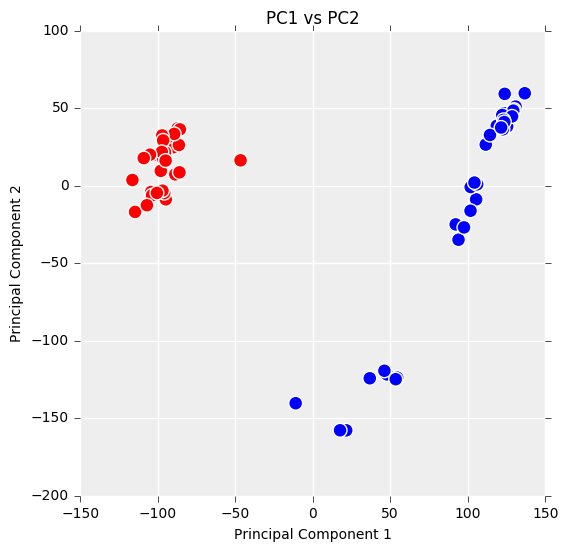

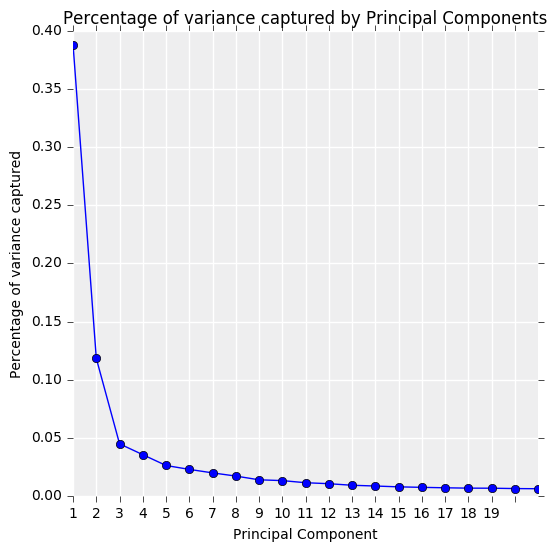

In [14]:
colors = ['red' if x else 'blue' for x in spleen]
evals, P_spl_thm, idxes = project(mean_centered_log2, 2)
plot_pcs(P_spl_thm, 0, 1, c=colors)
plot_var(evals, idxes, 20)

# Clustering

In [3]:
import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
import matplotlib.colors as mcolors

def linkage(mat):
    gene_link = fastcluster.linkage(mat, method='ward', metric='correlation')
    cell_link = fastcluster.linkage(mat.T, method='ward', metric='correlation')

    gene_order = hier.leaves_list(gene_link)
    cell_order = hier.leaves_list(cell_link)

    reordered_data_subset = mat.values[gene_order, :]
    reordered_data_subset = reordered_data_subset[:, cell_order]
    #reordered_data_subset = log2_cpm.ix[gene_order, cell_order]
    return gene_link, cell_link, reordered_data_subset

# From: http://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

def heatmap(gene_link, cell_link, reordered_data_subset):
    fig = plt.figure(figsize=(16, 8), dpi=96)
    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 2,
                           width_ratios=[1,10],
                           height_ratios=[1,10],
                           wspace=0.05,
                           hspace=0.05)


    # # x ywidth height
    ax1 = fig.add_subplot(gs[0,1], frameon=False)
    Z1 = hier.dendrogram(cell_link, orientation='top', ax=ax1) # adding/removing the axes
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = fig.add_subplot(gs[1,0], frameon=False)
    Z2 = hier.dendrogram(gene_link, orientation='left', ax=ax2) # adding/removing the axes
    ax2.set_xticks([])
    ax2.set_yticks([])

    axmatrix = fig.add_subplot(gs[1,1])
    # norm=mpl.colors.Normalize(vmin=0, vmax=40)
    c = mcolors.ColorConverter().to_rgb
    gbr = make_colormap(
            [c('black'), c('green'), 0.33, c('green'), c('red'), 0.66, c('red')])
    im = axmatrix.matshow(reordered_data_subset.T, aspect='auto', origin='lower', cmap=gbr, interpolation='none')
    axmatrix.set_xticks([])
    axmatrix.set_yticks([])

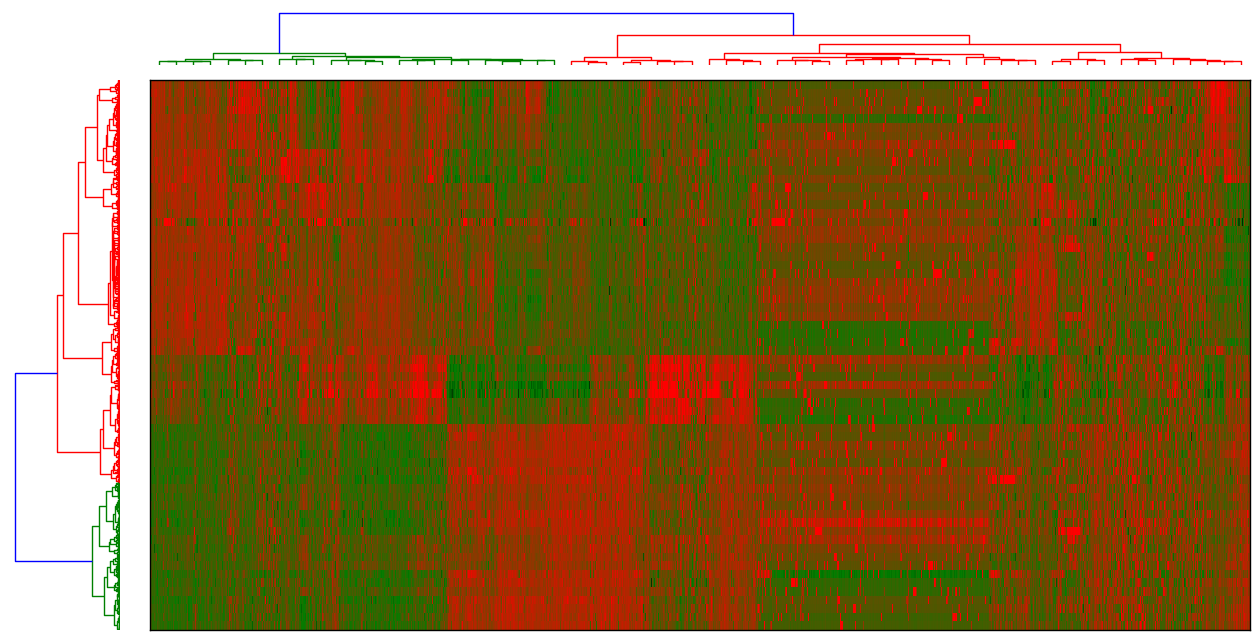

In [16]:
z_scores = ((log2_cpm.T-log2_cpm.mean(axis=1))/(log2_cpm.std(axis=1))).T
gene_link, cell_link, reordered_data_subset = linkage(z_scores)
heatmap(gene_link, cell_link, reordered_data_subset)

# Differential Gene Expression

## Volcano Plot

In [17]:
col1 = np.ones(64)
col2 = [int(i) for i in spleen]
X = np.matrix([col1,col2]).T

In [18]:
annotation = pd.DataFrame(filtered_count_df['Geneid'])
organ = pd.Series(spleen)
design = pd.DataFrame(X)

#Push the necessary data to R
%Rpush filtered_counts organ design annotation

#Load the edgeR and limma libraries
%R library(edgeR)
%R library(limma)

#Put the counts, groups, and annotation into a 'DGEList' object 
%R x <- DGEList(counts=filtered_counts, group=organ, genes=annotation)

#TMM Normalization
%R x <- calcNormFactors(x)

#Filter out genes that don't have at least 1 count-per-million in at least 20 samples
%R isexpr <- rowSums(cpm(x) > 1) >= 20
%R x <- x[isexpr,]

#Run voom
%R voomResults <- voom(x,design)

#Run limma
%R fit <- eBayes(lmFit(voomResults,design))

#Save the results
%R limmaResults <- topTable(fit,sort="p",n=Inf,coef=2)

#Pull the results back to python, dragging the correct row names along by force (ugh, R-Python interface)
%R rowNames <- rownames(limmaResults)
%Rpull limmaResults
%Rpull rowNames

#Make sure to set the correct row names
limmaResults = limmaResults.set_index(rowNames)

,Geneid,logFC,AveExpr,t,P.Value,adj.P.Val,B
3834,Nkx2-3,7.685359,-0.201999,53.512123,2.643867e-55,4.222256e-51,111.425328


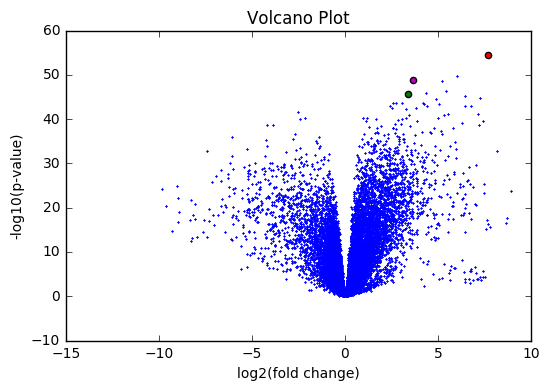

In [34]:
plt.scatter(limmaResults['logFC'], -np.log10(limmaResults['P.Value']),s=1,marker='x')
Nkx2 = limmaResults[limmaResults['Geneid'] == 'Nkx2-3']
Cfp = limmaResults[limmaResults['Geneid'] == 'Cfp']
Unc5c = limmaResults[limmaResults['Geneid'] == 'Unc5c']
plt.scatter(Nkx2['logFC'],-np.log10(Nkx2['P.Value']),s=20,c='r')
plt.scatter(Cfp['logFC'],-np.log10(Cfp['P.Value']),s=20,c='g')
plt.scatter(Unc5c['logFC'],-np.log10(Unc5c['P.Value']),s=20,c='m')
plt.xlabel('log2(fold change)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')

## Significant Genes

In [20]:
threshold_logFC = 2
threshold_pAdjusted = 0.05

genesPassingLogFCThreshold = (abs(limmaResults['logFC']) > threshold_logFC)
genesPassingPValueThreshold = limmaResults['adj.P.Val'] < 0.05

DEGenes = limmaResults.ix[genesPassingLogFCThreshold & genesPassingPValueThreshold]
DEGenes.sort('logFC',ascending=False)
DEGenes.sort('adj.P.Val',ascending=True)

/net/rcstorenfs02/ifs/rc_labs/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/net/rcstorenfs02/ifs/rc_labs/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Geneid,logFC,AveExpr,t,P.Value,adj.P.Val,B
3834,Nkx2-3,7.685359,-0.201999,53.512123,2.643867e-55,4.222256e-51,111.425328
21675,Hmcn1,6.016893,6.432951,44.844427,1.821088e-50,1.454139e-46,104.997767
6070,Unc5c,3.648120,4.040294,43.230972,1.809427e-49,9.632184e-46,102.586909
13762,Hs6st2,5.204390,2.773363,43.022398,2.448974e-49,9.777529e-46,101.648026
3871,Kazald1,5.421516,2.638117,39.661298,3.918885e-47,1.251692e-43,96.691868
11932,Col8a2,3.374900,4.512648,39.277539,7.173536e-47,1.909356e-43,96.752182
19101,Adgre4,4.377538,4.334860,38.786211,1.568094e-46,3.577495e-43,95.923241
12545,Cfp,3.405652,6.782883,38.596123,2.127333e-46,4.246689e-43,95.701608
8324,Adamtsl2,6.479127,3.590033,37.869029,6.919874e-46,1.227893e-42,94.107719
10078,Defb24,7.241801,-0.402603,37.377549,1.554126e-45,2.481940e-42,91.763607


## MA Plot

In [21]:
spleen_cnt = filtered_counts.T.ix[list(organ)].sum(axis=0)
spleen_cnt.name = 'Spleen'
thymus_cnt = filtered_counts.T.ix[list(~organ)].sum(axis=0)
thymus_cnt.name = 'Thymus'

In [22]:
countSummary = pd.concat([filtered_count_df['Geneid'], spleen_cnt, thymus_cnt], axis=1)
countSummary.set_index('Geneid', inplace=True)
countSummary.head()

,Spleen,Thymus
Geneid,,
Vom2r3,5,4
Vom2r6,9,10
Vom2r5,0,1
Raet1l,417,229
AABR07000109.1,12,15


In [23]:
summary_libraries = tmm_norm(countSummary)
summary_libraries

,group,lib.size,norm.factors,effective.lib.size
Spleen,1,393918815.0,1.001990,3.947027e+08
Thymus,1,422502966.0,0.998014,4.216638e+08


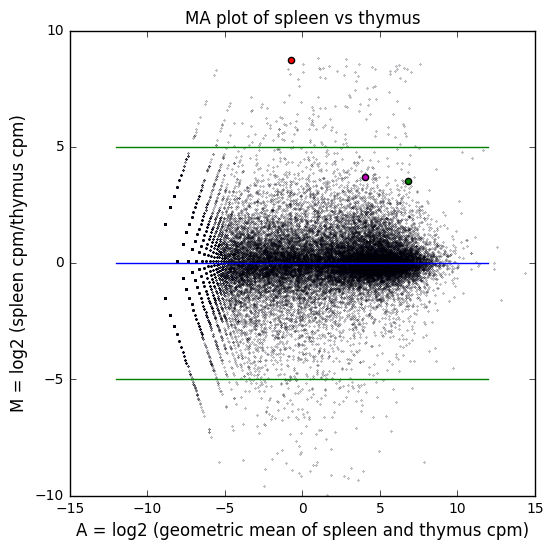

In [33]:
R_Spleen = np.sum(countSummary['Spleen'])
R_eff_Spleen = R_Spleen * summary_libraries.ix['Spleen', 'norm.factors']
R_Thymus = np.sum(countSummary['Thymus'])
R_eff_Thymus = R_Thymus * summary_libraries.ix['Thymus', 'norm.factors']
cpm_Spleen = 1e6*(countSummary['Spleen']+0.5)/(R_eff_Spleen + 1)
cpm_Thymus = 1e6*(countSummary['Thymus']+0.5)/(R_eff_Thymus + 1)

logcpm_Spleen = np.log2(cpm_Spleen)
logcpm_Thymus = np.log2(cpm_Thymus)

M = logcpm_Spleen - logcpm_Thymus
A = np.log2((cpm_Spleen * cpm_Thymus) ** 0.5)

plt.figure(num=None, figsize=(6, 6)) #test
plt.scatter(A,M,s=0.05)
plt.ylim([-10, 10])
plt.xlim([-15, 15])
plt.plot([-12,12],[0,0],c='blue')
plt.plot([-12,12],[5,5],c='green')
plt.plot([-12,12],[-5,-5],c='green')
plt.scatter(A.ix['Nkx2-3'],M.ix['Nkx2-3'],s=20,c='r')
plt.scatter(A.ix['Cfp'],M.ix['Cfp'],s=20,c='g')
plt.scatter(A.ix['Unc5c'],M.ix['Unc5c'],s=20,c='m')
plt.xlabel('A = log2 (geometric mean of spleen and thymus cpm)',fontsize=12)
plt.ylabel('M = log2 (spleen cpm/thymus cpm)',fontsize=12)
plt.title("MA plot of spleen vs thymus",fontsize=12)

# Gene Set Analysis

In [35]:
rat_to_human = pd.read_csv('/n/regal/scrb152/Data/Reference/Rattus_norvegicus/rat_to_human.csv')
rat_to_human.set_index('Rat Gene Symbol', inplace=True)
rat_to_human.head()

,Human Gene Symbol
Rat Gene Symbol,
Plekhg2,PLEKHG2
Cers6,CERS6
Cers4,CERS4
Plekhg1,PLEKHG1
Hspbap1,HSPBAP1


In [36]:
hum_genes = filtered_count_df[filtered_count_df['Geneid'].isin(rat_to_human.index)]
hum_genes['Geneid'] = hum_genes['Geneid'].apply(lambda x: rat_to_human.ix[x])
hum_filtered_counts = hum_genes.iloc[:, 6:]
hum_filtered_counts.head()

/net/rcstorenfs02/ifs/rc_labs/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Spl_F_002_1,Spl_F_002_2,Spl_F_002_3,Spl_F_002_4,Spl_F_006_1,Spl_F_006_2,Spl_F_006_3,Spl_F_006_4,Spl_F_021_1,Spl_F_021_2,...,Thm_M_006_3,Thm_M_006_4,Thm_M_021_1,Thm_M_021_2,Thm_M_021_3,Thm_M_021_4,Thm_M_104_1,Thm_M_104_2,Thm_M_104_3,Thm_M_104_4
14,70,103,116,197,129,82,85,71,103,115,...,159,98,85,81,131,106,219,209,213,160
17,211,222,234,337,256,199,228,190,136,182,...,547,374,249,212,278,232,165,240,292,125
18,969,1316,1115,1749,1957,1086,1260,1032,1043,1309,...,2389,1660,1103,1176,1598,1372,1417,1653,2049,866
19,272,320,299,490,523,330,395,328,249,295,...,937,500,367,298,461,355,262,293,419,151
20,399,463,456,669,685,450,618,573,261,398,...,529,319,288,294,408,367,1609,736,1028,610


In [37]:
annotation = pd.DataFrame(hum_genes['Geneid'])
organ = pd.Series(spleen)
design = pd.DataFrame(X)

#Push the necessary data to R
%Rpush hum_filtered_counts organ design annotation

#Load the edgeR and limma libraries
%R library(edgeR)
%R library(limma)

#Put the counts, groups, and annotation into a 'DGEList' object 
%R x <- DGEList(counts=hum_filtered_counts, group=organ, genes=annotation)

#TMM Normalization
%R x <- calcNormFactors(x)

#Filter out genes that don't have at least 1 count-per-million in at least 20 samples
%R isexpr <- rowSums(cpm(x) > 1) >= 20
%R x <- x[isexpr,]

#Run voom
%R voomResults <- voom(x,design)

#Run limma
%R fit <- eBayes(lmFit(voomResults,design))

#Save the results
%R limmaResults <- topTable(fit,sort="p",n=Inf,coef=2)

#Pull the results back to python, dragging the correct row names along by force (ugh, R-Python interface)
%R rowNames <- rownames(limmaResults)
%Rpull limmaResults
%Rpull rowNames

#Make sure to set the correct row names
limmaResults = limmaResults.set_index(rowNames)

In [38]:
%%R
# Load up Homo sapiens gene annotation objects
library("org.Hs.eg.db")
# Convert the relevant Homo sapiens gene annotations object to a list
geneSymbolToEntrezID = as.list(org.Hs.egALIAS2EG)
# Remove pathway identifiers that do not map to any entrez gene id
geneSymbolToEntrezID = geneSymbolToEntrezID[!is.na(geneSymbolToEntrezID)]
# Keep only the first element
geneSymbolToEntrezID = sapply(geneSymbolToEntrezID, function(x) x[1])

# Map gene symbols used in our experiment to Entrez IDs, keep same gene order as in voomResults
voomResultsGeneColumnAsEntrezIDs = sapply(voomResults$gene$Geneid, function(x) geneSymbolToEntrezID[toString(x)])

# Print
print(voomResultsGeneColumnAsEntrezIDs)

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: AnnotationDbi

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-p

          LRP11           NUP43           LATS1          KATNA1           GINM1 
        "84918"        "348995"          "9113"         "11104"        "116254" 
          PPIL4         ZC3H12D            TAB2             UST           SASH1 
        "85313"        "340152"         "23118"         "10090"         "23328" 
          SAMD5          STXBP5            ADGB           RAB32           SHPRH 
       "389432"        "134957"         "79747"         "10981"        "257218" 
         FBXO30           EPM2A            UTRN           STX11           SF3B5 
        "55294"          "7957"          "7402"          "8676"         "83443" 
         PLAGL1            LTV1         PHACTR2           FUCA2            PEX3 
         "5325"         "84946"          "9749"          "2519"          "8504" 
          ADAT2            AIG1          HIVEP2            VTA1          CITED2 
       "134637"         "51390"          "3097"         "51534"         "10370" 
          TXLNB            H

In [39]:
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c1_v5p2.rdata", "human_c1_v5p2.rdata", mode = "wb")
%R load("human_c1_v5p2.rdata")
%R indices <- ids2indices(Hs.c1, voomResultsGeneColumnAsEntrezIDs)
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c1_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Content type 'text/plain; charset=UTF-8'
  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 105066 bytes (102 KB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 102 KB


  warnings.warn(x, RRuntimeWarning)


Empty DataFrame
Columns: [NGenes, Correlation, Direction, PValue, FDR]
Index: []


,NGenes,Correlation,Direction,PValue,FDR
chr15q13,20.0,-0.027500,Up,0.000243,0.079011
chr10p14,17.0,-0.011880,Down,0.008198,0.762897
chr16q13,22.0,-0.013346,Down,0.010007,0.762897
chr9q13,9.0,0.099731,Up,0.015584,0.762897
chr1p21,24.0,-0.016355,Up,0.016358,0.762897


In [40]:
# Download and load MSigDB collection C2 version 5 as a pre-processed R data object
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c2_v5p2.rdata", "human_c2_v5p2.rdata", mode = "wb")
%R load("human_c2_v5p2.rdata")
# For each gene set in MSigDB collection C2, map the gene to its index in our voomResults file
%R indices <- ids2indices(Hs.c2, voomResultsGeneColumnAsEntrezIDs)
# Run camera using our voomResults, the mapping of our genes to gene sets, and our design matrix
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c2_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 1318597 bytes (1.3 MB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 1.3 MB


  warnings.warn(x, RRuntimeWarning)


Empty DataFrame
Columns: [NGenes, Correlation, Direction, PValue, FDR]
Index: []


,NGenes,Correlation,Direction,PValue,FDR
ABDELMOHSEN_ELAVL4_TARGETS,14.0,-0.052351,Up,0.000039,0.098328
REACTOME_G_ALPHA_Z_SIGNALLING_EVENTS,37.0,-0.001979,Up,0.000056,0.098328
REACTOME_G_PROTEIN_ACTIVATION,21.0,-0.013557,Up,0.000093,0.098328
REACTOME_G_PROTEIN_BETA_GAMMA_SIGNALLING,25.0,-0.017671,Up,0.000097,0.098328
PID_THROMBIN_PAR1_PATHWAY,44.0,0.005548,Up,0.000104,0.098328


In [41]:
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c3_v5p2.rdata", "human_c3_v5p2.rdata", mode = "wb")
%R load("human_c3_v5p2.rdata")
%R indices <- ids2indices(Hs.c3, voomResultsGeneColumnAsEntrezIDs)
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c3_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 592091 bytes (578 KB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 578 KB


  warnings.warn(x, RRuntimeWarning)


Empty DataFrame
Columns: [NGenes, Correlation, Direction, PValue, FDR]
Index: []


,NGenes,Correlation,Direction,PValue,FDR
V$ETS2_B,229.0,0.005078,Up,0.002465,0.998858
V$PAX5_02,16.0,-0.024493,Up,0.009755,0.998858
"GCAAGAC,MIR-431",38.0,-0.007589,Down,0.013029,0.998858
"GCGCCTT,MIR-525,MIR-524",13.0,-0.039318,Up,0.013891,0.998858
V$PPARG_01,36.0,-0.001518,Down,0.020934,0.998858


In [42]:
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c4_v5p2.rdata", "human_c4_v5p2.rdata", mode = "wb")
%R load("human_c4_v5p2.rdata")
%R indices <- ids2indices(Hs.c4, voomResultsGeneColumnAsEntrezIDs)
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c4_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 230021 bytes (224 KB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 224 KB


  warnings.warn(x, RRuntimeWarning)


Empty DataFrame
Columns: [NGenes, Correlation, Direction, PValue, FDR]
Index: []


,NGenes,Correlation,Direction,PValue,FDR
GNF2_SPI1,25.0,0.101864,Up,0.001757,0.946391
MODULE_540,8.0,-0.068032,Up,0.002457,0.946391
MODULE_298,14.0,0.259608,Down,0.008148,0.946391
GNF2_TNFSF10,23.0,0.246099,Up,0.008522,0.946391
MODULE_68,14.0,0.250882,Down,0.009852,0.946391


In [43]:
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c5_v5p2.rdata", "human_c5_v5p2.rdata", mode = "wb")
%R load("human_c5_v5p2.rdata")
%R indices <- ids2indices(Hs.c5, voomResultsGeneColumnAsEntrezIDs)
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c5_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 2165915 bytes (2.1 MB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 2.1 MB


  warnings.warn(x, RRuntimeWarning)


                           NGenes  Correlation Direction    PValue       FDR
GO_PLATELET_MORPHOGENESIS    18.0    -0.023592        Up  0.000003  0.016386


,NGenes,Correlation,Direction,PValue,FDR
GO_PLATELET_MORPHOGENESIS,18.0,-0.023592,Up,0.000003,0.016386
GO_BARBED_END_ACTIN_FILAMENT_CAPPING,11.0,-0.068589,Up,0.000030,0.063469
GO_BONE_CELL_DEVELOPMENT,19.0,-0.022995,Up,0.000031,0.063469
GO_POSITIVE_REGULATION_OF_PHOSPHOPROTEIN_PHOSPHATASE_ACTIVITY,10.0,-0.061635,Up,0.000067,0.103619
GO_OTIC_VESICLE_DEVELOPMENT,12.0,-0.008224,Down,0.000192,0.161761


In [44]:
%%R
# Again map gene symbols into Entrez IDs, but this time in the same order as the genes in limmaResults
limmaResultsGeneColumnAsEntrezIDs = sapply(limmaResults$Geneid, function(x) geneSymbolToEntrezID[toString(x)])
limmaIndices = ids2indices(Hs.c5, limmaResultsGeneColumnAsEntrezIDs)

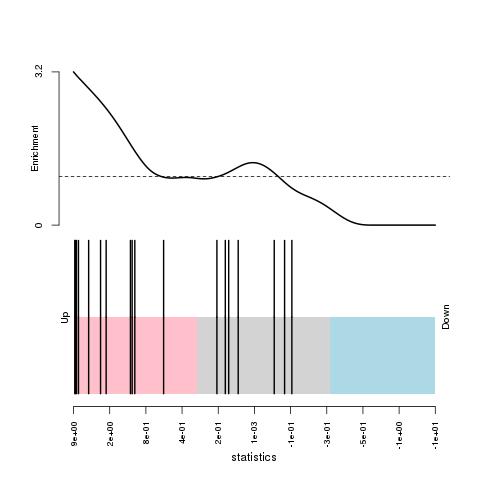

In [45]:
%R barcodeplot(limmaResults$logFC, limmaIndices[['GO_PLATELET_MORPHOGENESIS']], quantiles=c(-0.3,0.3))

In [46]:
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c6_v5p2.rdata", "human_c6_v5p2.rdata", mode = "wb")
%R load("human_c6_v5p2.rdata")
%R indices <- ids2indices(Hs.c6, voomResultsGeneColumnAsEntrezIDs)
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c6_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 93706 bytes (91 KB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 91 KB


  warnings.warn(x, RRuntimeWarning)


Empty DataFrame
Columns: [NGenes, Correlation, Direction, PValue, FDR]
Index: []


,NGenes,Correlation,Direction,PValue,FDR
MTOR_UP.V1_UP,137.0,0.002526,Down,0.025504,0.965249
BCAT_BILD_ET_AL_UP,40.0,0.032461,Up,0.060077,0.965249
SNF5_DN.V1_UP,144.0,0.013249,Up,0.062960,0.965249
HOXA9_DN.V1_UP,162.0,0.066741,Up,0.074670,0.965249
RPS14_DN.V1_UP,152.0,0.119521,Up,0.075025,0.965249


In [47]:
%R download.file("http://bioinf.wehi.edu.au/software/MSigDB/human_c7_v5p2.rdata", "human_c7_v5p2.rdata", mode = "wb")
%R load("human_c7_v5p2.rdata")
%R indices <- ids2indices(Hs.c7, voomResultsGeneColumnAsEntrezIDs)
%R cameraResults <- camera(voomResults, indices, design)
%R rowNames <- rownames(cameraResults)
%Rpull cameraResults
%Rpull rowNames

cameraResults = cameraResults.set_index(rowNames)
print cameraResults.ix[cameraResults['FDR']<0.05]
cameraResults.head()

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: trying URL 'http://bioinf.wehi.edu.au/software/MSigDB/human_c7_v5p2.rdata'

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  length 2878133 bytes (2.7 MB)

  warnings.warn(x, RRuntimeWarning)
/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: downloaded 2.7 MB


  warnings.warn(x, RRuntimeWarning)


Empty DataFrame
Columns: [NGenes, Correlation, Direction, PValue, FDR]
Index: []


,NGenes,Correlation,Direction,PValue,FDR
GSE17186_NAIVE_VS_CD21LOW_TRANSITIONAL_BCELL_CORD_BLOOD_DN,179.0,0.006891,Up,0.000417,0.947099
GSE17721_LPS_VS_POLYIC_24H_BMDC_DN,175.0,0.007063,Up,0.001140,0.947099
GSE22140_GERMFREE_VS_SPF_ARTHRITIC_MOUSE_CD4_TCELL_UP,170.0,0.016942,Up,0.001652,0.947099
GSE17186_NAIVE_VS_CD21HIGH_TRANSITIONAL_BCELL_DN,185.0,0.008360,Up,0.002373,0.947099
GSE27786_NKCELL_VS_NKTCELL_UP,184.0,0.011046,Up,0.002476,0.947099


# Fig 1 C

In [8]:
full_count = pd.read_csv('/n/regal/scrb152/Data/Yu_et_al/full_counts_matrix.csv')
fullCounts = full_count.iloc[:, 1:]
# Remove rows with all 0 counts
filtered_fullCounts = fullCounts.loc[(fullCounts!=0).any(axis=1)]

In [9]:
libs = tmm_norm(filtered_fullCounts)
full_log2_cpm = log_cpm(filtered_fullCounts, libs)

/n/scrb152/Software/Python/pyscrb152/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: limma

  warnings.warn(x, RRuntimeWarning)


In [10]:
z_scores = ((full_log2_cpm.T-full_log2_cpm.mean(axis=1))/(full_log2_cpm.std(axis=1))).T

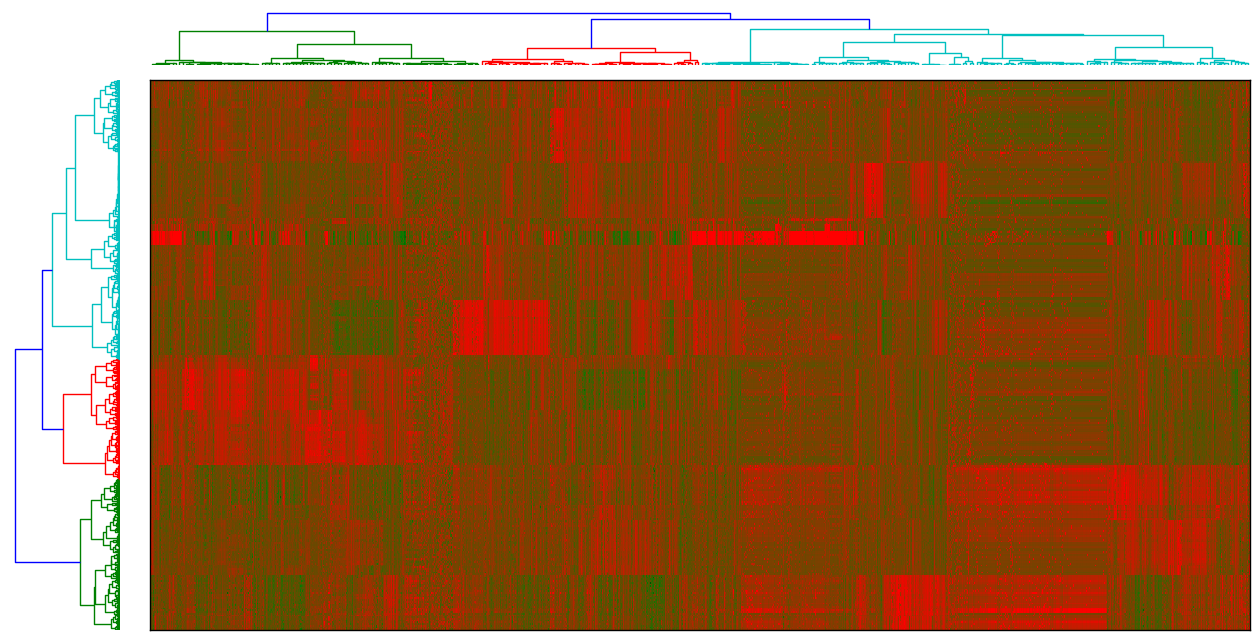

In [11]:
full_gene_link, full_cell_link, full_reordered_data_subset = linkage(z_scores)
heatmap(full_gene_link, full_cell_link, full_reordered_data_subset)